# Exoplanet cleaning and classification

This is the first part of a two-part workshop focused on cleaning and classifying exoplanet candidates observed by the Kepler space telescope. This data set is not easy to work with, and the focus of this first workshop is to study and clean the data.


<p float="left">
  <img src="https://upload.wikimedia.org/wikipedia/commons/4/45/Kepler_Space_Telescope_spacecraft_model_2.png" width="200" />
  <img src="https://exoplanets.nasa.gov/system/resources/detail_files/280_656348main_ToV_transit_diag.jpg" width="500" /> 
</p>

Data described and downloaded from https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data/

The following two links describes how Kepler observes exoplanets: [video1](https://www.youtube.com/watch?v=RrusIZaWDW8) and [video2](https://www.youtube.com/watch?v=ku7YjMol1k4). For extra credit here is a video proving that Kepler observed an [alien superstructure!](https://www.youtube.com/watch?v=nlDv7FspChA)

Before we begin, download and unzip the training and test data sets into the `./data/` folder.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(f'Pandas version {pd.__version__}')

Pandas version 1.0.0


In [4]:
def load_data(path):
    train_data = pd.read_csv(path)

    # Convert columns to something more useful.
    for i, column in enumerate(train_data.columns):
        if 'FLUX' in column:
            train_data.columns.values[i] = int(column.split('.')[1])
    # Also change labels so 0 is non-exoplanet and 1 is exoplanet
    train_data.LABEL -= 1
    return train_data

train_data = load_data('./data/exoTrain.csv')

LABEL -> 1 is an exoplanet star and 0 is a non-exoplanet-star.

Columns 1-3197 -> the light intensity recorded for each star, at a different point in time during the 80 day campaign

In [5]:
train_data.head()

,LABEL,1,2,3,4,5,6,7,8,9,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Data set ballance
How many exoplanet vs non-exoplanet labels are there?

In [6]:
print(f'Number of exoplanet labels {sum(train_data.LABEL == 1)}')
print(f'Number of non-exoplanet labels {sum(train_data.LABEL == 0)}')

Number of exoplanet labels 37
Number of non-exoplanet labels 5050


So this is an unballanced data set. Maybe the 37 exoplanets are very large (similar size to Jupiter and relatively easy to detect), but those planets are less common as smaller planets?

Star 5017 is very interesting. Its a periodic signal but not contain a planet.

## Visualize exoplanet and non-exoplanet light curves.

First lets pick n_plots random exoplanet and non-exoplanet examples and save to new DataFrames. For these examples we will also calculate a n_smooth running average and save them to another DataFrames. The running average calculation is nearly identical to a convolution and is the central concept in a Convolutional Naural Network we will use to classify Kepler light curves as exoplanet or non-exoplanet.

In [7]:
n_plots = 5
n_smooth = 100

exo_df = train_data[train_data.LABEL == 1].sample(n=n_plots, random_state=123)
nonexo_df = train_data[train_data.LABEL == 0].sample(n=n_plots, random_state=123)

exo_df_rolling = exo_df.rolling(n_smooth, axis=1, center=True).mean()
nonexo_df_rolling = nonexo_df.rolling(n_smooth, axis=1, center=True).mean()

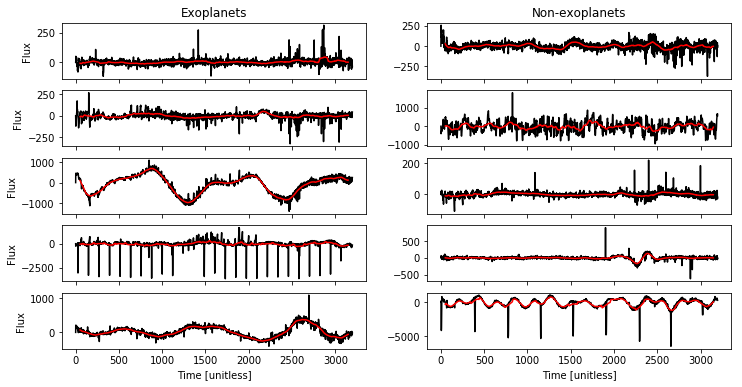

In [8]:
_, ax = plt.subplots(n_plots, 2, figsize=(12, 6), sharex=True)

for i, a in enumerate(ax[:, 0]): 
    a.plot(exo_df.iloc[i, :].values, 'k')
    a.plot(exo_df_rolling.values[i, :], 'r')
    a.set_ylabel('Flux')
for i, a in enumerate(ax[:, 1]): 
    a.plot(nonexo_df.iloc[i, :].values, 'k')
    a.plot(nonexo_df_rolling.values[i, :], 'r')
ax[0,0].set(title='Exoplanets')
ax[0,1].set(title='Non-exoplanets')
ax[-1,0].set_xlabel('Time [unitless]')
ax[-1,1].set_xlabel('Time [unitless]');

## Power spectrum
By visual inspection it is hard to tell the difference. What about the power spectrum?

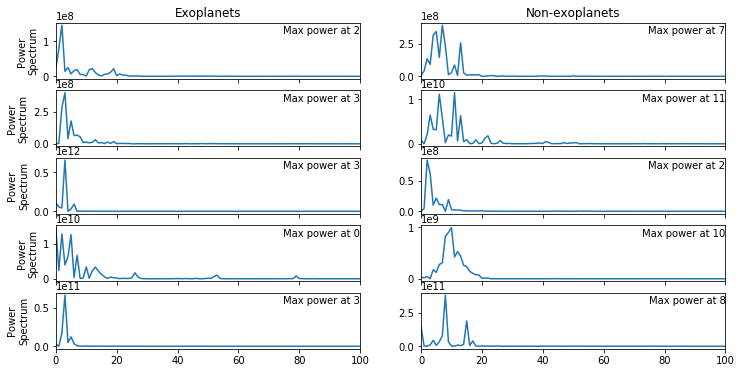

In [9]:
# Fill NaNs with 0s so numpy fft can handle the data correctly.
exo_df_rolling = exo_df_rolling.fillna(value=0)
nonexo_df_rolling = nonexo_df_rolling.fillna(value=0)

def calc_fourier_power(df):
    """
    Calculates the Fourier power spectrum and returns
    the frequency with the highest power.
    """
    ps = np.abs(np.fft.fft(df.values))**2
    max_power_f = np.argmax(ps[:len(ps)//2])
    return ps, max_power_f

### Plot the power spectra ###
_, ax = plt.subplots(n_plots, 2, figsize=(12, 6), sharex=True)

for i, a in enumerate(ax[:, 0]): 
    ps, max_power_f = calc_fourier_power(exo_df_rolling.iloc[i, :])
    a.plot(ps)
    a.text(1, 0.8, f'Max power at {max_power_f}', 
            ha='right', transform=a.transAxes)
    a.set_ylabel('Power\nSpectrum')

for i, a in enumerate(ax[:, 1]): 
    ps, max_power_f = calc_fourier_power(nonexo_df_rolling.iloc[i, :])
    a.text(1, 0.8, f'Max power at {max_power_f}', 
            ha='right', transform=a.transAxes)
    a.plot(ps)

ax[0,0].set(title='Exoplanets', xlim=(0, 100))
ax[0,1].set(title='Non-exoplanets');

There does not seem to be a pattern in this data so lets throw the biggest hammer we have-a Convolutional Neural Network (CNN)! Next workshop we will develop a CNN to classify this data set. Since this data set is far from ideal, we have two preprocessing tasks:

1. write a function to normalize each light curve by subtracticting the mean and dividing by the standard deviation and 
2. write a batch function that given the training set, training labels, and a batch_size arguments, will output batch_size number random light curves with HALF exoplanets and HALF non-exoplanets.

The  half detections batch function output requirement is our attempt to balance the data set.

In [10]:
def normalize_data(df):
    """
    Normalize a Kepler light curve DatFrame with a mean subtraction and 
    """
    # Calculate the mean of each light curve and subtract it
    df_norm = df.copy()
    mean = df_norm.iloc[:, 1:].mean(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].subtract(mean, axis=0)
    # Calculate the standard deviation of each light curve and divide.
    std = df_norm.iloc[:, 1:].std(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].divide(std, axis=0)
    return df_norm

In [11]:
df_norm = normalize_data(train_data)
df_norm.head()
#df_norm.to_csv('./data/exoTrain_preprocessed.csv', index=False)

,LABEL,1,2,3,4,5,6,7,8,9,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
0,1,0.521974,0.459509,0.063126,-0.229790,-0.308059,-0.837834,-0.902975,-0.660890,-0.558979,...,-0.547656,-0.697473,-0.697473,0.094421,0.240257,0.513824,0.182707,0.320205,-0.030324,-0.307935
1,1,-0.524105,-0.439954,-0.851711,-0.544268,-1.197814,-1.089501,-1.318459,-1.298129,-1.275467,...,0.069120,-0.412959,-0.412959,-0.290981,0.042791,0.136440,-0.071188,0.231423,0.390394,0.455882
2,1,1.860570,1.872206,1.793484,1.733848,1.590274,1.624154,1.618833,1.696491,1.519711,...,-0.283383,0.018167,0.018167,-0.135091,-0.103127,-0.011101,-0.070914,-0.131615,-0.277459,-0.372004
3,1,3.207775,3.409928,2.973657,2.932781,3.122729,3.073910,3.167189,3.060446,3.071198,...,0.100317,0.008878,0.008878,0.336081,0.239025,-0.077717,-0.039941,-0.122661,-0.123049,0.180422
4,1,-2.684628,-2.697843,-2.713465,-2.654883,-2.562650,-2.505984,-2.417214,-2.477073,-2.395673,...,-1.424955,-0.951607,-0.951607,-0.842499,-1.055016,-1.042194,-0.946817,-0.909826,-0.976489,-1.219045


In [12]:
def light_curve_batch_generator(x, y, batch_size=32):
    """
    Returns equal number of random exoplanets and non-exoplanet detections.
    """
    idx_exo = np.where(y==1)[0]
    idx_nonexo = np.where(y==0)[0]
 
    while True:
        random_idx_exo = np.random.choice(idx_exo, size=batch_size//2, replace=True)
        random_idx_nonexo = np.random.choice(idx_nonexo, size=batch_size//2, replace=True)
        random_idx = np.concatenate((random_idx_exo, random_idx_nonexo))
        np.random.shuffle(random_idx)

        train_data = x[random_idx, :, :]
        train_labels = y[random_idx, :]

        for i in range(batch_size):
            random_shift = np.random.randint(train_data.shape[1])
            train_data[i] = np.roll(train_data[i], random_shift, axis=0)
        yield train_data, train_labels